In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import astropy

In [2]:
#from platform import python_version
#python_version()

In [3]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [4]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'Berkeley_102'

## Getting RA&DEC from Bica 2019

In [5]:
df = pd.read_csv('../../lista.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]
ra, dec

(354.66667, 56.64361)

## Querying the data

In [6]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [7]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [8]:
query = """SELECT 
ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' + ' 0.2))'

In [9]:
job = Gaia.launch_job_async(query)
job

INFO: Query finished. [astroquery.utils.tap.core]


In [10]:
data = job.get_results()
len(data)

9002

In [11]:
#data

## Converting to pandas

In [12]:
df = data.to_pandas()
df

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
0,354.861460,56.477700,-1.112115,0.256505,-0.591977,0.223118,1.556492,19.450947,-0.302992,0.242490,NaN,NaN,113.068842,-5.009157
1,354.862050,56.479028,-2.811201,0.805827,1.770919,0.611667,1.658403,20.553125,1.097222,0.749290,NaN,NaN,113.069524,-5.007971
2,354.863911,56.479785,3.576056,0.515956,-1.578914,0.456092,2.264957,20.268747,2.034311,0.516388,NaN,NaN,113.070726,-5.007527
3,354.845036,56.472143,-0.051441,0.531741,-0.185002,0.511777,NaN,20.202375,1.425605,0.501907,NaN,NaN,113.058550,-5.011993
4,354.861574,56.478405,-1.172799,1.721949,1.921989,1.109590,1.607468,20.779202,2.267578,1.418133,NaN,NaN,113.069098,-5.008497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8997,354.987861,56.731176,-0.318535,0.241469,-2.753390,0.251380,2.041758,19.366318,0.446979,0.238417,NaN,NaN,113.205954,-4.784595
8998,354.994620,56.726640,-3.108372,0.022029,-2.087701,0.021287,1.018134,15.148191,0.544933,0.022179,NaN,NaN,113.208285,-4.789974
8999,354.988037,56.729450,-4.758284,1.333586,-3.753529,1.264254,1.398842,20.722332,-0.345658,1.054799,NaN,NaN,113.205572,-4.786282
9000,354.986474,56.737233,-2.491642,0.449101,-0.643544,0.458797,1.264980,20.164452,0.866114,0.433185,NaN,NaN,113.206885,-4.778562


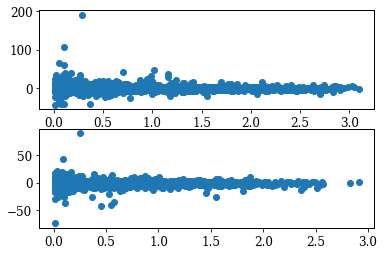

In [13]:
fig, ax = plt.subplots(2)

ax[0].scatter(df.pmra_error,df.pmra)
ax[1].scatter(df.pmdec_error,df.pmdec)

In [14]:
print(np.mean(df.pmdec), np.mean(df.pmdec_error)) ## por que pmra tem um erro muito maior?
print(np.mean(df.pmra), np.mean(df.pmra_error))

-1.3914756695327686 0.3566908538341522
-1.6277799370077157 0.42324087023735046


## Applying better conditions to the variables

In [15]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(3815, 9002)

## Dropping uknown values of pmra, pmdec or parallax.

In [16]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmdec', 'parallax'])
ndf

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
2,354.863911,56.479785,3.576056,0.515956,-1.578914,0.456092,2.264957,20.268747,2.034311,0.516388,NaN,NaN,113.070726,-5.007527
6,354.873774,56.481135,-2.274052,0.077283,-1.676433,0.067979,1.373905,17.597698,0.227654,0.074302,NaN,NaN,113.076355,-5.007732
7,354.888021,56.486953,8.920931,0.241389,-2.196724,0.219471,2.124969,19.146202,0.717018,0.234586,NaN,NaN,113.085556,-5.004309
9,354.897466,56.492218,-5.921432,0.485832,-2.625149,0.406455,1.788589,20.159365,1.321788,0.458671,NaN,NaN,113.092044,-5.000685
10,354.899962,56.492574,-3.638051,0.065272,-2.417838,0.058156,1.351160,17.233473,0.607682,0.064280,NaN,NaN,113.093472,-5.000722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,355.005242,56.703612,-1.217291,0.101429,-1.681788,0.101177,1.215586,18.042839,0.266552,0.101003,NaN,NaN,113.207581,-4.813719
8986,354.989587,56.708366,-1.991386,0.104874,-1.311145,0.106596,1.418596,18.200251,0.235296,0.104838,NaN,NaN,113.200594,-4.806792
8995,355.000452,56.723451,-8.984770,0.147354,-0.891491,0.145899,1.389627,16.271626,0.800872,0.152865,NaN,NaN,113.210496,-4.793917
8998,354.994620,56.726640,-3.108372,0.022029,-2.087701,0.021287,1.018134,15.148191,0.544933,0.022179,NaN,NaN,113.208285,-4.789974


In [17]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import silhouette_score
#from sklearn.metrics import v_measure_score
from sklearn.preprocessing import StandardScaler

## Creating the arrays to perform the 5-D HDBSCAN fit

In [18]:
X = np.dstack((ndf['pmra'],ndf['pmdec']))[0]
cincoD = np.dstack((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax']))[0]

In [19]:
sc = StandardScaler()

escalada = sc.fit_transform(cincoD)

## Performing the HDBSCAN

In [20]:
import hdbscan

Estimated no. of clusters: 1
Estimated no. of noise points: 2443
Estimated no. points clustered: 572


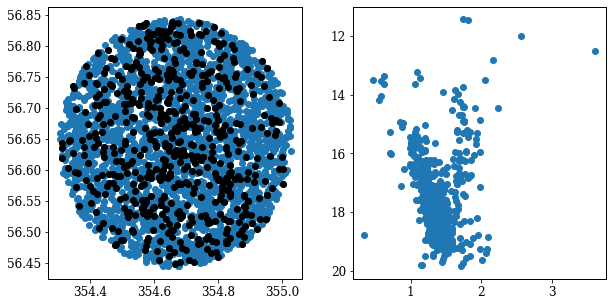

In [42]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples = 1, allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(cincoD)

labels = clusterer.labels_


ndf = ndf.assign(labels=labels)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)

ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


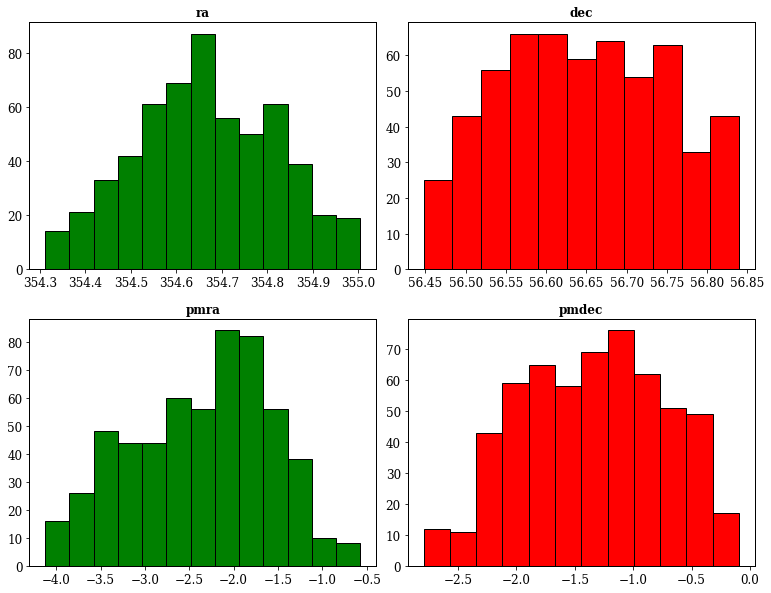

In [22]:
fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax1.hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax2.hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax3.hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax4.hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


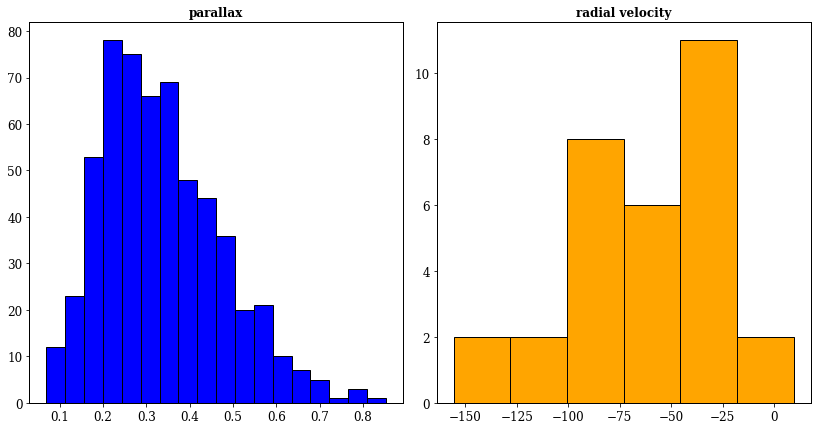

In [23]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax1.hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## Constructing a RDP and histograms of the clusters parameters

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

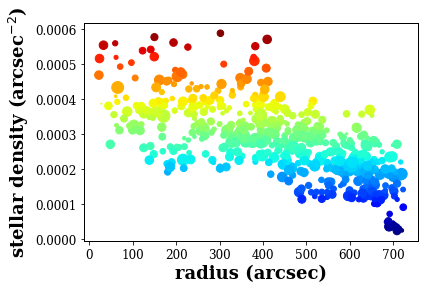

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors


catalog = SkyCoord(ra=subset['ra']*units.degree, dec=subset['dec']*units.degree, frame='fk5')

nstar = len(subset)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([subset['ra']*np.cos(subset['dec']*np.pi/180.0), subset['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(subset['ra'], weights=den_data)
std_x = np.average((subset['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(subset['dec'], weights=den_data)
std_y = np.average((subset['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



## Gaussian fit

In [25]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 18
    # variables        = 3
    chi-square         = 895.654603
    reduced chi-square = 59.7103068
    Akaike info crit   = 76.3292957
    Bayesian info crit = 79.0004109
[[Variables]]
    amplitude:  26.8258978 +/- 1.55756021 (5.81%) (init = 31.96013)
    center:     0.29373541 +/- 0.00952042 (3.24%) (init = 0.2995063)
    sigma:      0.14572985 +/- 0.01024940 (7.03%) (init = 0.1383556)
    fwhm:       0.34316756 +/- 0.02413549 (7.03%) == '2.3548200*sigma'
    height:     73.4371548 +/- 4.08596795 (5.56%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.639
    C(center, sigma)    = -0.121


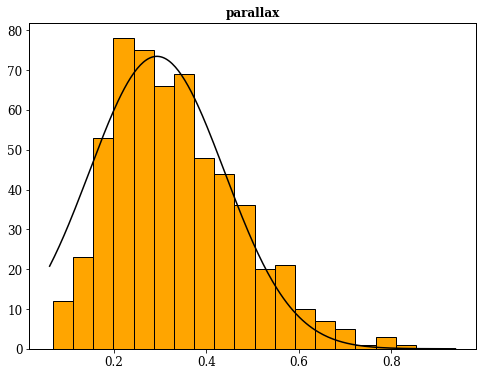

In [26]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 13
    # variables        = 3
    chi-square         = 740.047293
    reduced chi-square = 74.0047293
    Akaike info crit   = 58.5429416
    Bayesian info crit = 60.2377896
[[Variables]]
    amplitude:  34.7984212 +/- 2.23569756 (6.42%) (init = 31.66006)
    center:     354.664884 +/- 0.01379518 (0.00%) (init = 354.6698)
    sigma:      0.19298113 +/- 0.01516403 (7.86%) (init = 0.1445665)
    fwhm:       0.45443581 +/- 0.03570856 (7.86%) == '2.3548200*sigma'
    height:     71.9374092 +/- 4.45146965 (6.19%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.641


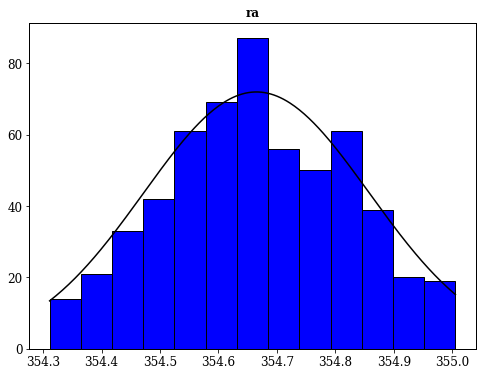

In [27]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 13
    # variables        = 3
    chi-square         = 1686.05058
    reduced chi-square = 168.605058
    Akaike info crit   = 69.2475321
    Bayesian info crit = 70.9423802
[[Variables]]
    amplitude:  178.913930 +/- 17.3037808 (9.67%) (init = 236.3238)
    center:    -2.26574317 +/- 0.10629970 (4.69%) (init = -2.298462)
    sigma:      0.98799628 +/- 0.11692121 (11.83%) (init = 1.036508)
    fwhm:       2.32655340 +/- 0.27532840 (11.83%) == '2.3548200*sigma'
    height:     72.2435259 +/- 6.72174140 (9.30%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.642


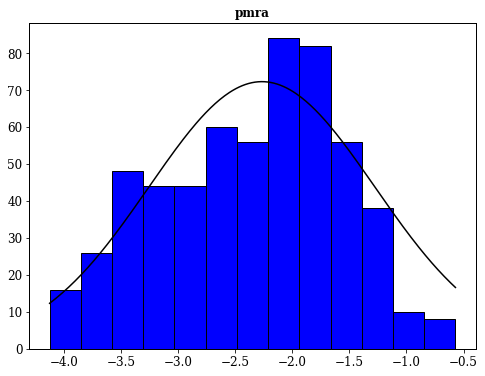

In [28]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 11
    # variables        = 3
    chi-square         = 524.106388
    reduced chi-square = 65.5132985
    Akaike info crit   = 48.5017936
    Bayesian info crit = 49.6954795
[[Variables]]
    amplitude:  28.2113198 +/- 2.55700294 (9.06%) (init = 14.45529)
    center:     56.6468201 +/- 0.01330618 (0.02%) (init = 56.64362)
    sigma:      0.17037685 +/- 0.02032745 (11.93%) (init = 0.1175227)
    fwhm:       0.40120682 +/- 0.04786749 (11.93%) == '2.3548200*sigma'
    height:     66.0576165 +/- 4.06682361 (6.16%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.863


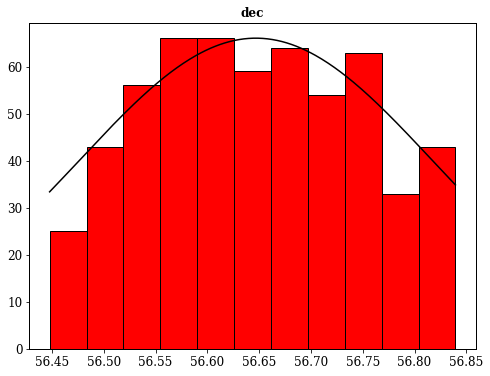

In [29]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 12
    # variables        = 3
    chi-square         = 741.285178
    reduced chi-square = 82.3650198
    Akaike info crit   = 55.4817451
    Bayesian info crit = 56.9364650
[[Variables]]
    amplitude:  154.269018 +/- 10.8698852 (7.05%) (init = 167.4549)
    center:    -1.29319231 +/- 0.06376366 (4.93%) (init = -1.199137)
    sigma:      0.83891885 +/- 0.07448219 (8.88%) (init = 0.858743)
    fwhm:       1.97550289 +/- 0.17539214 (8.88%) == '2.3548200*sigma'
    height:     73.3616093 +/- 4.72664607 (6.44%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.695
    C(center, sigma)    = 0.114


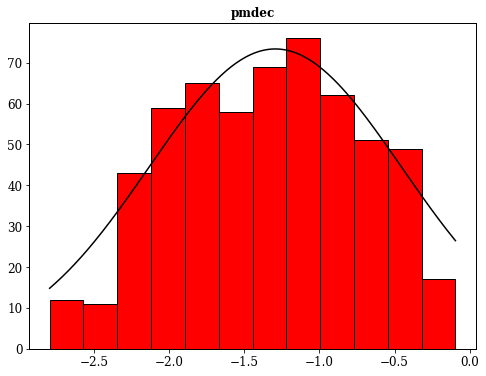

In [30]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 6
    # variables        = 3
    chi-square         = 28.6489232
    reduced chi-square = 9.54964107
    Akaike info crit   = 15.3801383
    Bayesian info crit = 14.7554167
[[Variables]]
    amplitude:  1073.65578 +/- 308.337192 (28.72%) (init = 742.2236)
    center:    -50.2987666 +/- 15.2920181 (30.40%) (init = -23.59182)
    sigma:      47.7791793 +/- 16.8573427 (35.28%) (init = 27.48976)
    fwhm:       112.511367 +/- 39.6960076 (35.28%) == '2.3548200*sigma'
    height:     8.96471461 +/- 2.43226117 (27.13%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.658
    C(center, sigma)     = 0.149
    C(amplitude, center) = 0.118


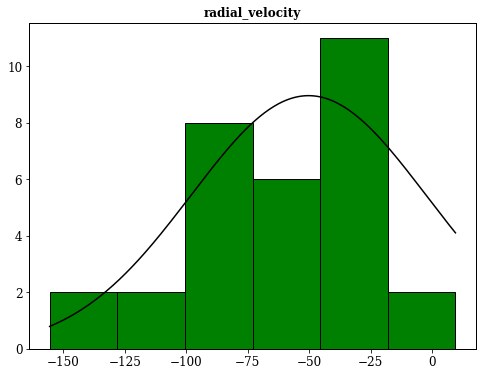

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'green');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]

valores_radial_velocity= [result.params['center'].value, result.params['sigma'].value]


xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('radial_velocity', fontweight = 'bold')

plt.show()

572
178


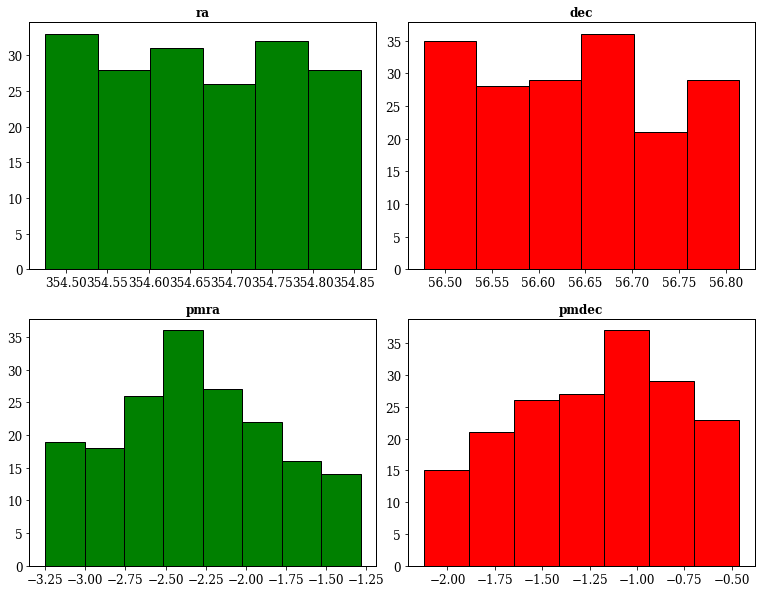

In [32]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 1

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)  & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))

fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax1.hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax2.hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax3.hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax4.hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


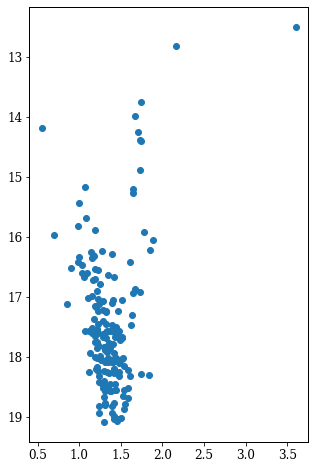

In [33]:
plt.figure(figsize=(5,8))
plt.scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'])
plt.gca().invert_yaxis()

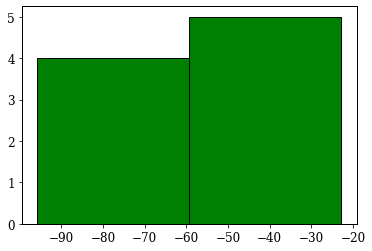

In [34]:
ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']

plt.hist(data, optimal_bin, ec = 'k',color = 'green');

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

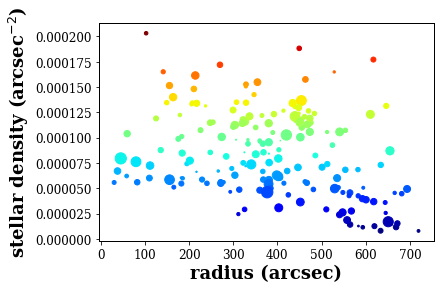

In [35]:
from astropy.coordinates import SkyCoord
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()
ax.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



In [36]:
center

<SkyCoord (ICRS): (ra, dec) in deg
    (354.6609894, 56.6324386)>

In [37]:
final = df.loc[(df.parallax < paralaxe_up ) & (df.parallax > paralaxe_down) & (df.ra>ra_down) & (df.ra<ra_up) & 
                              (df.dec>dec_down) & (df.dec<dec_up) & (df.pmra>pmra_down) & (df.pmra<pmra_up) & (df.pmdec>pmdec_down) 
                              & (df.pmdec<pmdec_up)  & (df.radial_velocity.isnull() | (df.radial_velocity>radvel_down) & (df.radial_velocity<radvel_up)) ]

In [38]:
clip_loop.to_csv('final_5d.csv', index=False)

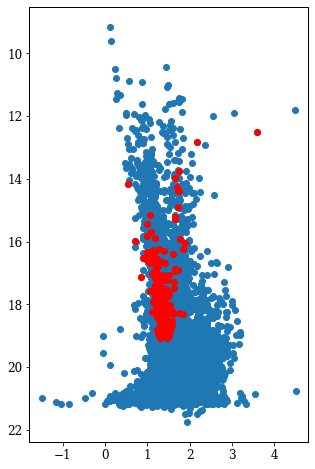

In [39]:
plt.figure(figsize=(5,8))
plt.scatter(df['bp_rp'],df['phot_g_mean_mag'])
plt.scatter(clip_loop['bp_rp'], clip_loop['phot_g_mean_mag'], color = 'red')
plt.gca().invert_yaxis()

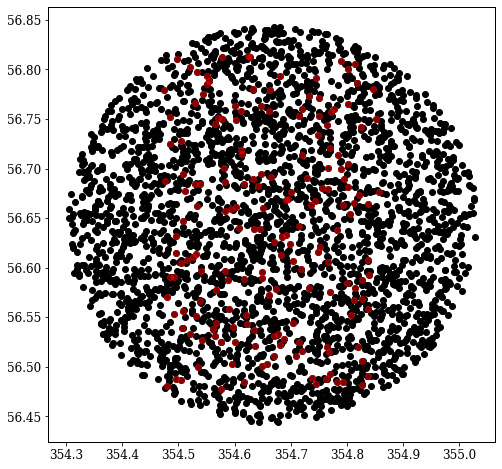

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(ndf['ra'],ndf['dec'], color = 'k')
plt.scatter(clip_loop['ra'],clip_loop['dec'], color = 'red', alpha = 0.5)